## Wavelet Propagation on a Sample of Traffic Data

### Purpose & Motivation

Fourier transform analysis of the mean flow waveform indicates there are several strong cyclical components.  Analysis of specific frequencies within the wiggle waveforms themselves may provide useful data for visualizing wiggle propagation in both time and space.

### Hypothesis

We can isolate the wiggles using wavelets and plot them in time/space to identify propagation.

### Tasks/Questions to Answer

#### Questions to Answer
1. Can we identify a wavelet form appropriate for wiggle analysis?
2. Given a wavelet, can we identify parameters for extracting the wiggles?
3. Using wiggle-wavelet transforms, can we analyze wiggle propagation?

#### Tasks
1. Select wavelet form
2. Explore wavelet parameters
3. Apply wavelet to traffic data
4. Visualize the wiggle-wavelet propagation

### Imports and data prep

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.fftpack
import pandas as pd
import numpy as np
from scipy import signal
import time
import datetime as dt
import matplotlib
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import wavelet_lib as wl

from IPython.display import Image

In [4]:
data_dir = "../../../data/"
data_5min_path = data_dir + "5min/2015/d11/"
meta_path = data_dir + "meta/2015/d11/"

df = pd.read_csv( data_dir + '2015_station_days_with_meta.csv', usecols=range(1,20))
df = df.ix[df['Partition'] == 'Weekdays']
flow_df = df.pivot(index='Station', columns='Time', values='Flow')

/Users/monkey/anaconda/envs/capstone/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/Users/monkey/anaconda/envs/capstone/lib/python2.7/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


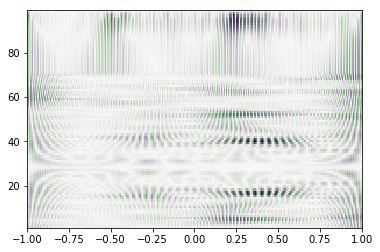

In [5]:
a = flow_df[flow_df.index==1108148]
a = np.array(a.transpose())
a = np.concatenate(a)
widths = np.arange(1, 100, 1)
cwtmatr = signal.cwt(a, signal.morlet, widths)
plt.imshow(cwtmatr, extent=[-1, 1, min(widths), max(widths)], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

Continuous wavelet transform shows magnitude of transform with denser colors.  Green is positive, purple is negative.  

In [6]:
import wavelet_lib as wl
reload(wl)

<module 'wavelet_lib' from 'wavelet_lib.pyc'>

In [36]:
flow_df.index.unique()

Int64Index([1108148, 1108285, 1108287, 1108289, 1108291, 1108293, 1108295,
            1108297, 1108299, 1108302,
            ...
            1126006, 1126016, 1126022, 1126027, 1126035, 1126148, 1126156,
            1126163, 1126175, 1126191],
           dtype='int64', name=u'Station', length=839)

In [52]:
def plot_morlet(omega, scaling, station=1108148):
    a = flow_df[flow_df.index==1108148]
    a = np.array(a.transpose())
    a = np.concatenate(a)
    a = np.repeat(a, 5)

    plt.figure(figsize=(15,3))
    my_wave = signal.morlet(len(a),w=omega,s=scaling)
    #print len([i for i in my_wave if abs(i)>.01])

    plt.plot(my_wave)
    mid = len(my_wave)/2
    plt.vlines([mid, mid+60, mid - 60], -.8, .8, alpha=0.25, colors='red')
    plt.vlines([mid-15, mid-45, mid+15, mid+45], -.8, .8, linestyles='dashed', alpha=0.1)
    plt.vlines([mid+30, mid-30], -.8, .8, alpha=0.15)
    plt.xticks([mid, mid+60, mid-60], ['0hr', '1hr', '-1hr'])
    plt.show()
    
    plt.figure(figsize=(15,8))
    wt = wl.my_wavelet_transform(a,my_wave)
    plt.plot(wt, color='b', label = 'transform (omega {})'.format(str(omega)))
    plt.plot(a, color='r', label = 'original signal')
    plt.plot(wl.smooth_amplitude(wt)*100, color='g', label = 'tranform smoothed')
    plt.vlines([(len(a)/24)*j for j in range(25)],-1000,1000, alpha=0.25, colors='red')
    plt.vlines([(len(a)/24)*j+30 for j in range(25)],-1000,1000, alpha=0.1, linestyles='dashed')
    plt.ylabel('Flow')
    xticks = range(0, 1441, 60)
    plt.xticks( xticks, ['{:02}:00'.format(i) for i in range(len(xticks))], rotation=45 )
    
    plt.legend()
    plt.show()
    

### Wavelet Selection

There are several options for wavelet shape (below).  Given the fairly cyclic nature of the wiggles, we opted for the Morlet wavelet form.

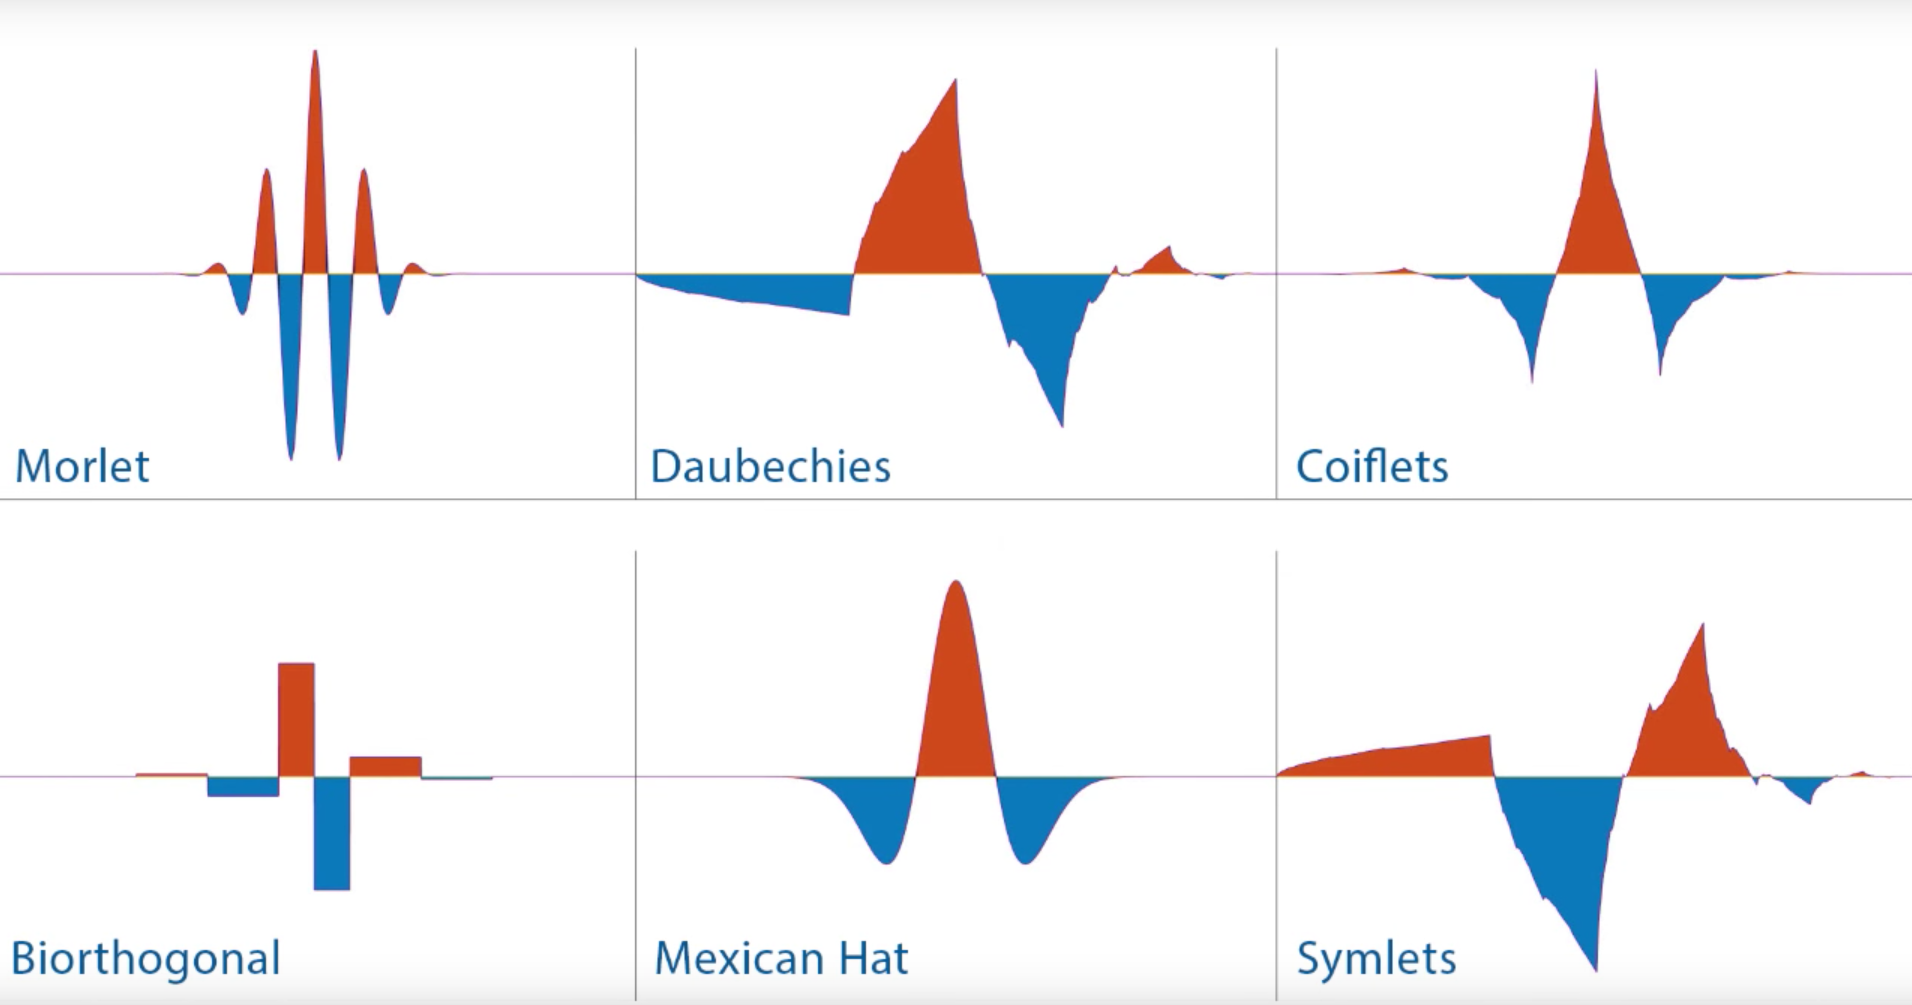

In [25]:
Image("wavelet_examples.png")

### Wavelet Tuning

Having selected a wavelet form, we then experimented with the wavelet parameters, namely the $\omega$ value and the scaling factor.

Higher values of $\omega$ result in more oscillations of the waveform.  For example, $\omega = 5$ produces a wavelet containing about five oscillations, whereas $\omega = 2$ exhibits about two oscillations.

The scaling factor controls the relative frequency of the wavelet form.  Lower scaling values result in lower frequency of the oscillations.  For example, a wavelet with $\omega = 5$ and a scaling value of 5, results in a waveform with a period of approximately 0.5 hours and a scaling value of 2 results in a waveform with a period closer to 1.0 hours.

The following graphs illustrate some of the experimental values of $\omega$ and the scaling factor.



#### $\omega = 1$, $\text{ scaling factor} = 1$
The resulting wavelet has a period close to 5 hours.  The transform of this wavelet and the traffic sample results in an exagerated version of the mean traffic flow.

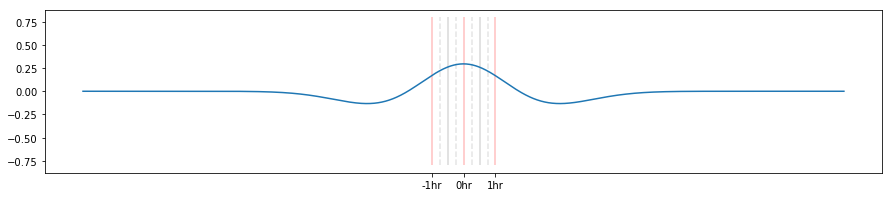

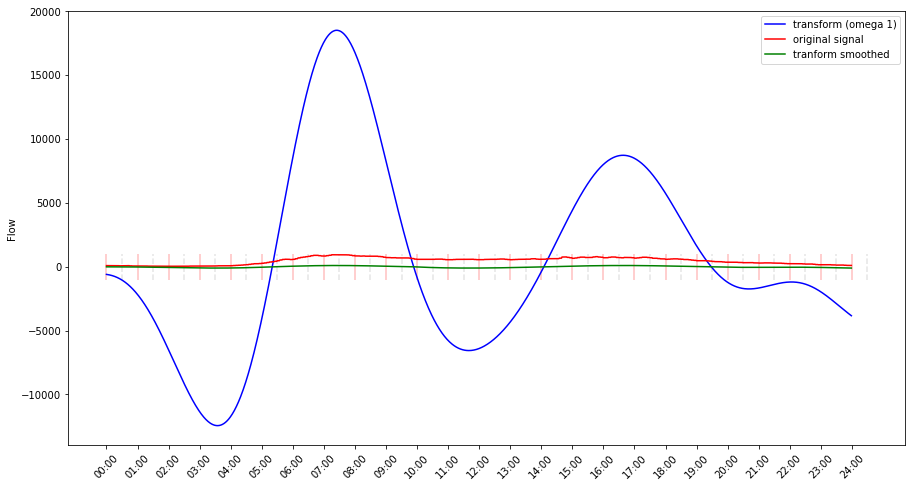

In [53]:
plot_morlet( omega=1, scaling=1 )

#### $\omega = 5$, $\text{ scaling factor} = 5$
The resulting wavelet has a period close to $\frac{1}{2}$ hour with five oscillations.  The transform of this wavelet and the traffic sample seems to follow the wiggle frequency but is heavily also influenced by the magnitude.

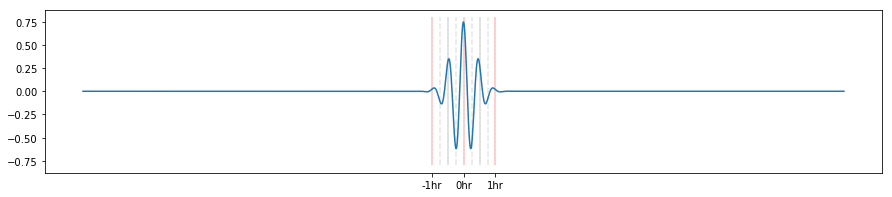

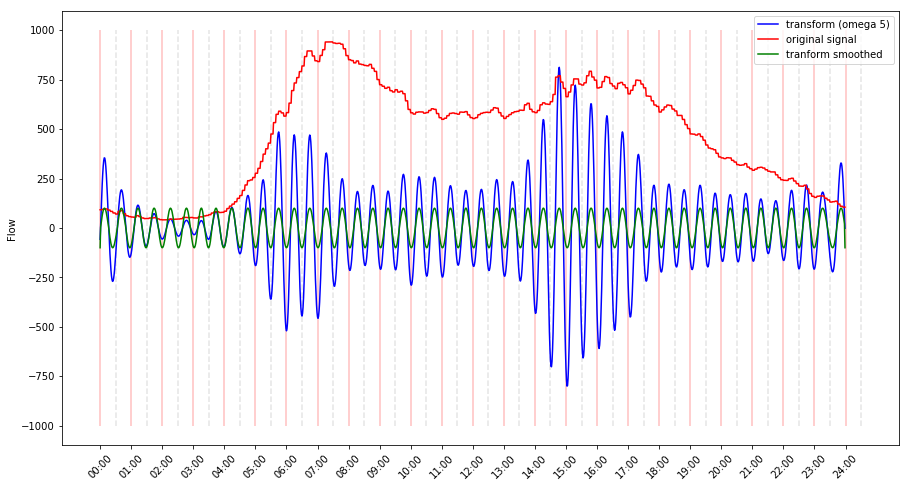

In [54]:
plot_morlet( omega=5, scaling=5 )

#### $\omega = 3$, $\text{ scaling factor} = 8$
The resulting wavelet has a period close to $\frac{1}{2}$ hour and only three oscillations.  The transform of this wavelet and the traffic sample seems to follow the wiggle frequency but is heavily also influenced by the magnitude.  We selected this parameterization for the remainder of the analysis.

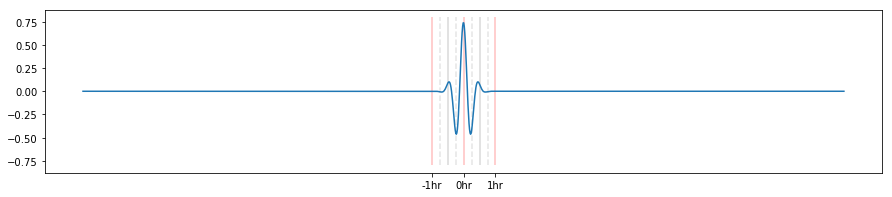

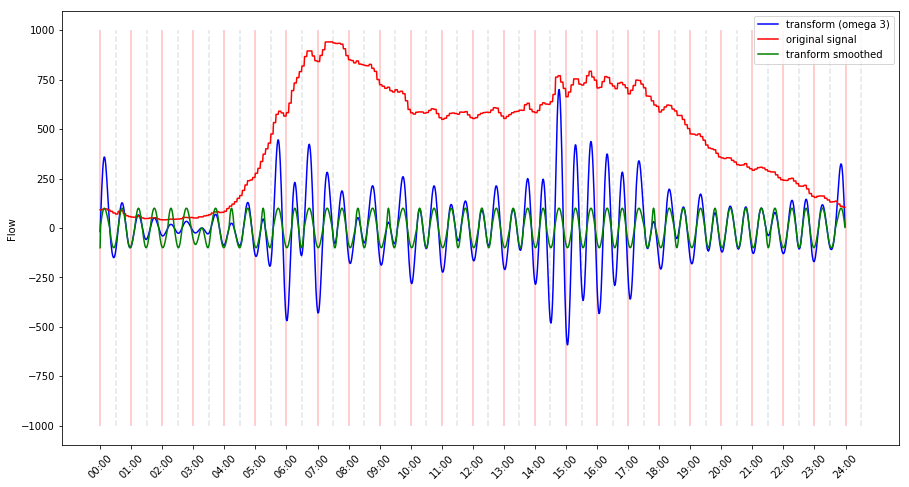

In [55]:
plot_morlet( omega=3, scaling=8 )

134


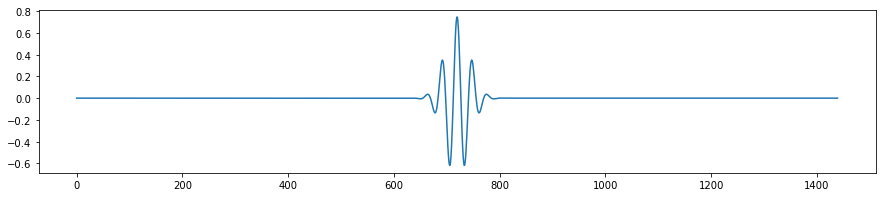

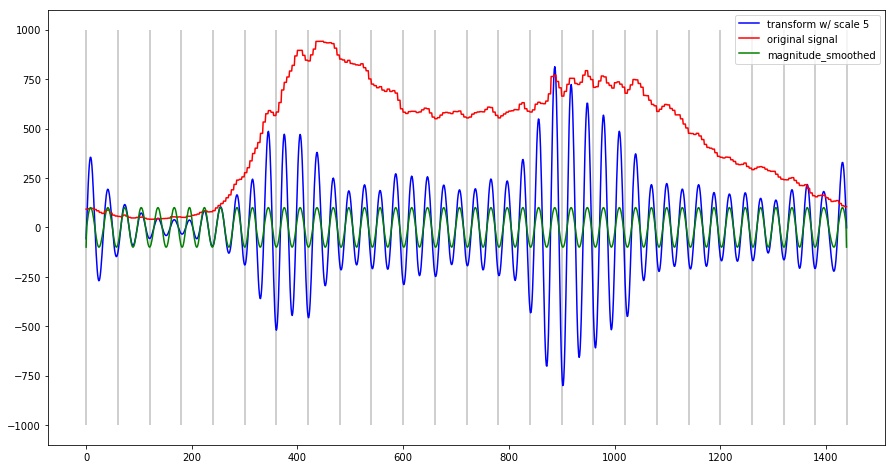

In [39]:
width = 5
my_s = 5
a = flow_df[flow_df.index==1108148]
a = np.array(a.transpose())
a = np.concatenate(a)
a = np.repeat(a, 5)



plt.figure(figsize=(15,3))
my_wave = signal.morlet(len(a),w=width,s=my_s)
print len([i for i in my_wave if abs(i)>.01])

plt.plot(my_wave)
plt.show()
plt.figure(figsize=(15,8))
wt = wl.my_wavelet_transform(a,my_wave)
plt.plot(wt, color='b', label = 'transform w/ scale {}'.format(str(width)))
plt.plot(a, color='r', label = 'original signal')
plt.plot(wl.smooth_amplitude(wt)*100, color='g', label = 'magnitude_smoothed')
plt.vlines([(len(a)/24)*j for j in range(25)],-1000,1000, alpha=0.25)

plt.legend()
plt.show()

In [40]:
#meta_path = '../data/station_5min/2015/meta_data/d11/'
meta_file = meta_path + 'd11_text_meta_2015_12_17.txt'
meta_df = pd.read_csv( meta_file, delimiter='\t' ) \
    .rename( columns={'ID':'Station'}) \
    .set_index('Station')

In [50]:
my_wave = signal.morlet( len(a), w=3, s=8 )

def wiggle_heatmap(freeway=5, direction='S', lanetype='ML'):
    idx1 = meta_df['Fwy'] == freeway
    idx2 = meta_df['Dir'] == direction
    idx3 = meta_df['Type'] == lanetype
    fwy_df = meta_df.ix[idx1&idx2&idx3,:].sort_values('Abs_PM', ascending=False)
    
    my_list = []
    for station in fwy_df.index:
        a = flow_df[flow_df.index==station]
        a = np.array(a.transpose())
        a = np.concatenate(a)
        a = np.repeat(a, 5)
        wt = wl.my_wavelet_transform(a,my_wave)
        my_list.append(wl.smooth_amplitude(wt))
    my_array = np.vstack(my_list)
    
    x_lims = [dt.datetime(2017,1,1,0,0,0),dt.datetime(2017,1,1,23,59,59)]
    x_lims = mdates.date2num(x_lims)
    y_lims = [0, len(my_list)]

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    title = 'Wiggle Propagation on {} {}'.format(fwy_df.Fwy.unique()[0], fwy_df.Dir.unique()[0])
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Station Order')
    #plt.xlabel('Time of Day')
    #plt.ylabel('Station Order')

    ax.imshow(np.real(my_array), cmap='hot', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]], 
          aspect='auto')
    
    vlines = [dt.datetime(2017,1,1,i,0,0) for i in range(24)]
    ax.vlines( vlines, 0, 101, colors='cyan', linestyles='dashed', linewidth=2)
    
    mask = (meta_df.Fwy==freeway) & (meta_df.Dir==direction) & (meta_df.Type.isin(['FF','ML']))
    m = meta_df[mask].sort_values('Abs_PM')
    i, ff, ffn = 0, [], []
    for n in m.iterrows():
        if n[1].Type == 'ML':
            i += 1
        else: 
            ff.append(i)
            ffn.append(n[1].Name)
    ax.hlines( ff, x_lims[0], x_lims[1], colors='magenta', linestyles='dashed', linewidth=2 )

    ax.xaxis_date()

    date_format = mdates.DateFormatter('%H:%M')

    ax.xaxis.set_major_formatter(date_format)

    fig.autofmt_xdate()

    plt.show()
    
    return my_array

### Wiggle Propagation

With our selected wavelet (Morlet) and parameters ($\omega = 3$, $\text{ scaling factor} = 8$), we performed a transformation on each of the stations of a freeway segment.

For this analysis, we selected the stations from the I-5 southbound (in San Diego).  The mean station flow  (for each station for the entire year of 2015) was transformed using the wavelet and a smoothing function.  The resulting series of magnitudes was then plotted using a heatmap with time on the x-axis and ordered station position (max y is northern-most station) on the y-axis.

In the heatmap below, the wiggle maximums are yellow and the minimums are black.  The dashed vertical green lines represent hourly time points.  The dashed horizontal magenta lines represent the intersection of other highways with the I5 south.

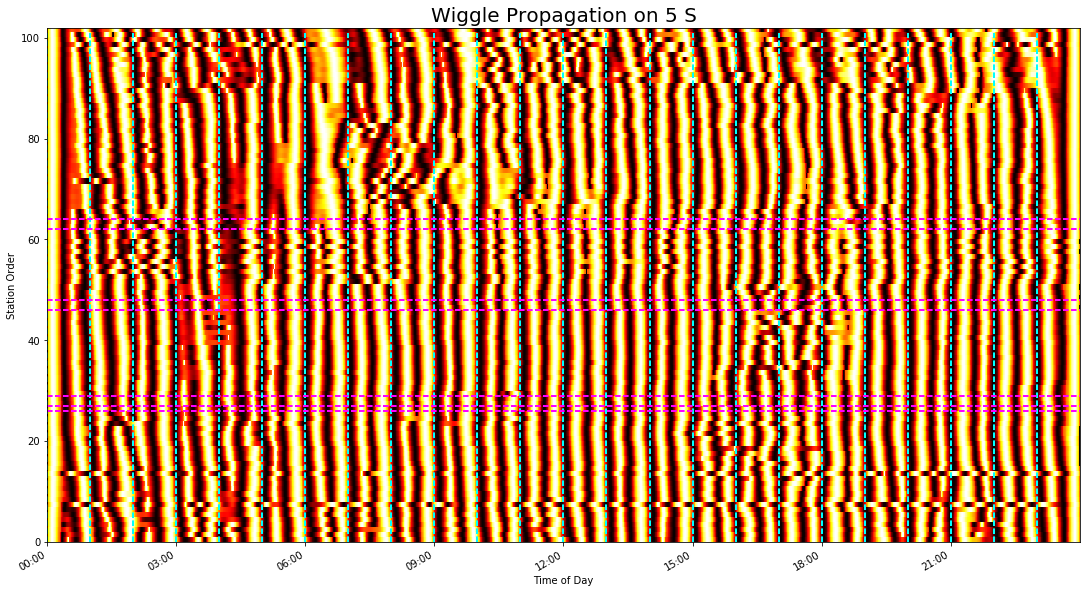

In [51]:
my_array = wiggle_heatmap( freeway=5, direction='S', lanetype='ML' )

In [59]:
idx1 = meta_df['Fwy'] == 5
idx2 = meta_df['Dir'] == 'S'
idx3 = meta_df['Type'] == 'ML'
fwy_df = meta_df.ix[idx1&idx2&idx3,:].sort_values('Abs_PM', ascending=False)
print len(fwy_df)

102


In [19]:
t1 = time.time()
my_list = []
for station in fwy_df.index:
    a = flow_df[flow_df.index==station]
    a = np.array(a.transpose())
    a = np.concatenate(a)
    a = np.repeat(a, 5)
    wt = wl.my_wavelet_transform(a,my_wave)
    my_list.append(wl.smooth_amplitude(wt))
my_array = np.vstack(my_list)
t2 = time.time()
t2-t1

72.83444499969482

In [47]:
my_wave = signal.morlet( len(a), w=3, s=8 )

# Generate some random data for imshow
N = 10
arr = np.random.random((N, N))

# Create your x-limits. Using two of your unix timestamps you first
# create a list of datetime.datetime objects using map.
x_lims = [dt.datetime(2017,1,1,0,0,0),dt.datetime(2017,1,1,23,59,59)]

# You can then convert these datetime.datetime objects to the correct
# format for matplotlib to work with.
x_lims = mdates.date2num(x_lims)

# Set some generic y-limits.
y_lims = [0, len(my_list)]

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
title = 'Wiggle Propagation on {} {}'.format(fwy_df.Fwy.unique()[0], fwy_df.Dir.unique()[0])
ax.set_title(title, fontsize=20)
#fig.set_title(title, fontsize=20)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Station Order', fontsize=16)
# Using ax.imshow we set two keyword arguments. The first is extent.
# We give extent the values from x_lims and y_lims above.
# We also set the aspect to "auto" which should set the plot up nicely.
ax.imshow(np.real(my_array), cmap='hot', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]], 
          aspect='auto')

vlines = [dt.datetime(2017,1,1,i,0,0) for i in range(24)]
ax.vlines( vlines, 0, 101, colors='cyan', linestyles='dashed', linewidth=2)

# We tell Matplotlib that the x-axis is filled with datetime data, 
# this converts it from a float (which is the output of date2num) 
# into a nice datetime string.
ax.xaxis_date()

# We can use a DateFormatter to choose how this datetime string will look.
# I have chosen HH:MM:SS though you could add DD/MM/YY if you had data
# over different days.
date_format = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_formatter(date_format)

# This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()

plt.show()

NameError: name 'my_list' is not defined

In [10]:
fwy_df.to_csv('station_order.csv')

In [11]:
pd.DataFrame(my_array).to_csv('wiggle_analysis.csv')

### Close-up of the time period 7am to 10am

In [64]:
start_time = 7
end_time = 10
small = np.real(my_array)[:,int(60*start_time):int(60*end_time)]

In [73]:
def wiggle_heatmap_segment( start_time, end_time ):
    small = np.real(my_array)[:,int(60*start_time):int(60*end_time)]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 10)
    
    title = 'Wiggle Propagation on {} {} between {} and {}'.format(
        fwy_df.Fwy.unique()[0], fwy_df.Dir.unique()[0], start_time, end_time )
    ax.set_title(title)
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Station Order')
    
    vlines = [i*60 for i in range((end_time-start_time)+1)]
    plt.xticks(vlines, ['{:02}:00'.format(i/60 + start_time) for i in vlines])
    ax.vlines( vlines, 0, 101, colors='cyan', linestyles='dashed', linewidth=2)
    ax.imshow(small, cmap='hot', aspect='auto' )
    
    plt.show()

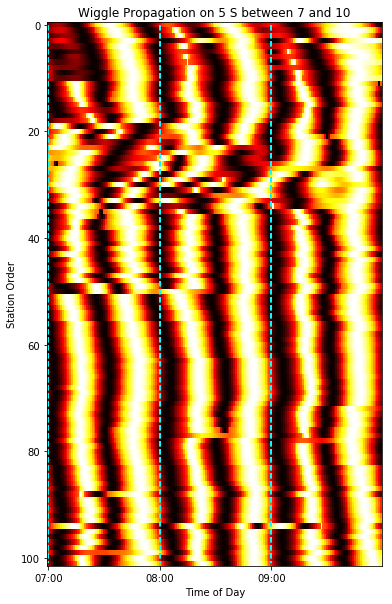

In [75]:
wiggle_heatmap_segment(7, 10)

### Results

The wavelets show some interesting results. The short wavelet scale seems to show very similar results to our wiggle extraction technique (calculating a smoothed mean and differencing it with the original signal). The larger scale wavelets seem to magnify the overall signal in the data.

There also seems to exist fluctuations within the propagation of the wiggle-wavelet peaks through time and space (as shown in the heatmap).  Areas of congestion appear to have a warping effect on the wiggles.

### Conclusions

Analysis of the propagation of the wiggles using wavelets seems to show promise.  Further exploration may be required.